## On Time Performance Exploration
## Samuel Sherman March 2016

### Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def read_and_select():
    #read as dataframes
    OTP_2013 = pd.read_csv("/Users/scsherm/Documents/CA/On_Time_On_Time_Performance_2013_8.csv", low_memory=False)
    OTP_2014 = pd.read_csv("/Users/scsherm/Documents/CA/On_Time_On_Time_Performance_2014_8.csv", low_memory=False)
    OTP_2015 = pd.read_csv("/Users/scsherm/Documents/CA/On_Time_On_Time_Performance_2015_8.csv", low_memory=False)
    
    #concatenate
    dframes = [OTP_2013, OTP_2014, OTP_2015]
    OTP = pd.concat(dframes)
    
    #select fields
    OTP = OTP[['Year', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'UniqueCarrier','Origin', 'OriginCityName','OriginStateName', 'Dest', 'DestCityName',
       'DestStateName', 'DepDelay', 'DepDelayMinutes', 'DepDel15',
       'TaxiOut', 'TaxiIn','ArrDelay','ArrDelayMinutes', 'ArrDel15', 
       'Cancelled', 'Diverted', 'AirTime', 'Distance',
       'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay']]
    OTP.reset_index(inplace = True)
    return OTP, OTP_2013, OTP_2014, OTP_2015

OTP, OTP_2013, OTP_2014, OTP_2015 = read_and_select()
OTP.head()


,index,Year,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,Origin,OriginCityName,OriginStateName,Dest,...,ArrDel15,Cancelled,Diverted,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2013,3,6,2013-08-03,9E,AUS,"Austin, TX",Texas,SLC,...,0,0,0,136,1086,NaN,NaN,NaN,NaN,NaN
1,1,2013,10,6,2013-08-10,9E,AUS,"Austin, TX",Texas,SLC,...,0,0,0,141,1086,NaN,NaN,NaN,NaN,NaN
2,2,2013,17,6,2013-08-17,9E,AUS,"Austin, TX",Texas,SLC,...,0,0,0,145,1086,NaN,NaN,NaN,NaN,NaN
3,3,2013,18,7,2013-08-18,9E,DFW,"Dallas/Fort Worth, TX",Texas,DTW,...,0,0,0,129,986,NaN,NaN,NaN,NaN,NaN
4,4,2013,1,4,2013-08-01,9E,MEM,"Memphis, TN",Tennessee,DTW,...,0,0,0,93,610,NaN,NaN,NaN,NaN,NaN


I excluded a fair amount of the fields. I included what I thought to be relevant towards my examination. There are clearly going to be certain attributes that are directly correlated to others, such as ArrDelay to DepDelay. However, I am looking to derive out unforeseen information in data and not what is completely apparent. I excluded all of the diverted aircraft information because, in my mind, it is too extensive, very sparse and could be considered leakage.  

In [2]:
OTP['FlightDate'] = pd.to_datetime(OTP['FlightDate'], format = '%Y-%m-%d')
type(OTP.FlightDate[0])

pandas.tslib.Timestamp

In [3]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
py.sign_in('scsherm', 'ml0wer7f1s')

delays_by_carrier = OTP.groupby(['UniqueCarrier'])['ArrDelay'].mean()
delays_by_carrier.sort_values(ascending = False, inplace = True)

data = [
    go.Bar(
        x=delays_by_carrier.index.values,
        y=delays_by_carrier.values
    )
]

layout = go.Layout(
    title='Mean Delays By Carrier',
    xaxis=dict(
        title='Carrier',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Mean Delays in Minutes',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig_carrierDelays = go.Figure(data=data, layout=layout)
py.iplot(fig_carrierDelays, strip_style = True, filename='ArrDelay-bar')


This is a graph of the mean delays per unique carrier. The airline Spirit (NK) has quite a significant amount of delays. Almost double that of the second biggest airline for delays, Frontier (F9). 

In [4]:
num_flights_per_carrier = OTP.groupby(['UniqueCarrier'])['Year'].count()
num_flights_per_carrier.sort_values(ascending = False, inplace = True)

data2 = [
    go.Bar(
        x=num_flights_per_carrier.index.values,
        y=num_flights_per_carrier.values
    )
]

layout2 = go.Layout(
    title='Number of Flights per Carrier',
    xaxis=dict(
        title='Carrier',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Number of Flights',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig_carrierCount = go.Figure(data=data2, layout=layout2)
py.iplot(fig_carrierCount, filename='Counts-bar')

Here, I am counting the number of data points per carrier as for comparison to the mean delays per carrier. What I find particularly interesting is that Delta Airlines (DL) has the second largest amount of flights, yet remains on the low end for its average delays. This might imply that it is a good airline for on time performance. At least for the month of August. Additionally, Spirit Airlines (NK) has the least number of flights, yet the highest mean delay time. Spirit Airlines appears to NOT be performing well at all.

In [5]:
delays_by_carrier_ts2013 = OTP_2013.groupby(['UniqueCarrier', 'FlightDate'], as_index=False)['ArrDelayMinutes'].mean()

data = []
for carrier in delays_by_carrier_ts2013.UniqueCarrier.unique():
    dat = delays_by_carrier_ts2013.query('UniqueCarrier == @carrier')
    ts = go.Scatter(x = dat.FlightDate, y = dat.ArrDelayMinutes, mode = 'lines', name = carrier)
    data.append(ts)
    
layout3 = go.Layout(
    title='Mean Delays per Carrier Over Time',
    xaxis=dict(
        title='Day',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Mean Delays',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)
fig_Del_Over_Time = go.Figure(data=data, layout=layout3)    
py.iplot(fig_Del_Over_Time, filename='delays_over_time')

Here, I am examining the mean delays over time for the month of August in 2013. The graph is a little messy but there appears to be some sort of cyclical pattern in how the delays are occuring. Also, these patterns seems to be consistent accross different airlines and could therefore suggest that an event occured. For example, on August 22nd there seems to be some sort of event that triggered delays across all the airlines. 

### Outliers

In [6]:
#origin destination matrix with sum of ArrDelayMinutes
origin_dest_mat = OTP.pivot_table(index = 'OriginStateName', columns = 'DestStateName', values = 'ArrDelayMinutes', 
                                  aggfunc='sum')
data = [go.Heatmap(
        x = origin_dest_mat.columns.values,
        y = origin_dest_mat.index.values,
        z = origin_dest_mat.values,
        autocolorscale = False,
        colorscale=[[0, 'rgb(220,220,220)'], [0.2, 'rgb(245,195,157)'], [0.4, 'rgb(245,160,105)'], 
                    [1, 'rgb(178,10,28)']])]

layout = go.Layout(
    autosize=False,
    barmode='overlay',
    height=1000,
    title='Total Delay By Origin State and Destination State (No Early Arrivals)',
    width=1000)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [7]:
CA = OTP.query('OriginStateName == "California" & DestStateName == "California"')
CA_ArrDelay = CA.ArrDelay
CA_ArrDelay = CA_ArrDelay.copy()
CA_ArrDelay.sort_values(ascending = False, inplace = True)
CA_ArrDelay[:10]

567658     1196
492425      542
835864      523
485226      498
1221637     488
926286      485
873077      467
444357      460
482860      429
535459      417
Name: ArrDelay, dtype: float64

In [8]:
TX = OTP.query('OriginStateName == "Texas" & DestStateName == "Texas"')
TX_ArrDelay = TX.ArrDelay
TX_ArrDelay = TX_ArrDelay.copy()
TX_ArrDelay.sort_values(ascending = False, inplace = True)
TX_ArrDelay[:10]

588737     1125
1343575     706
1073166     643
1099967     626
932306      609
1049857     559
1529612     543
1073397     499
225209      456
1321063     450
Name: ArrDelay, dtype: float64

In [9]:
OTP.iloc[567658,:]

index                               4737
Year                                2014
DayofMonth                            28
DayOfWeek                              4
FlightDate           2014-08-28 00:00:00
UniqueCarrier                         AA
Origin                               SFO
OriginCityName         San Francisco, CA
OriginStateName               California
Dest                                 LAX
DestCityName             Los Angeles, CA
DestStateName                 California
DepDelay                            1166
DepDelayMinutes                     1166
DepDel15                               1
TaxiOut                               48
TaxiIn                                10
ArrDelay                            1196
ArrDelayMinutes                     1196
ArrDel15                               1
Cancelled                              0
Diverted                               0
AirTime                               57
Distance                             337
CarrierDelay    

In [10]:
OTP.iloc[588737,:]

index                                25816
Year                                  2014
DayofMonth                              19
DayOfWeek                                2
FlightDate             2014-08-19 00:00:00
UniqueCarrier                           AA
Origin                                 IAH
OriginCityName                 Houston, TX
OriginStateName                      Texas
Dest                                   DFW
DestCityName         Dallas/Fort Worth, TX
DestStateName                        Texas
DepDelay                              1116
DepDelayMinutes                       1116
DepDel15                                 1
TaxiOut                                 27
TaxiIn                                   7
ArrDelay                              1125
ArrDelayMinutes                       1125
ArrDel15                                 1
Cancelled                                0
Diverted                                 0
AirTime                                 45
Distance   

From the graph above, I find particular interest in examining the flights from CA to CA and from TX to TX. Upon further examination of these flights, two particularly interesting events stand out as outliers. For each group of flight data, I sorted the flights by the Arrival Delay. In both situations you can notice a steady increase of the delays until the last value, which is almost doubled the value before it. These both stand out as odd instances, especially because the flight time is under an hour and the delay is almost twenty hours. The main cause appears to be carrier delay, but I would imagine this was an after effect from the late aircraft delay.   

In [11]:
#origin destination matrix with sum of ArrDelayMinutes
origin_dest_mat = OTP.pivot_table(index = 'OriginStateName', columns = 'DestStateName', values = 'ArrDelayMinutes', 
                                  aggfunc='mean')
data = [go.Heatmap(
        x = origin_dest_mat.columns.values,
        y = origin_dest_mat.index.values,
        z = origin_dest_mat.values,
        autocolorscale = False,
        colorscale=[[0, 'rgb(220,220,220)'], [0.2, 'rgb(245,195,157)'], [0.4, 'rgb(245,160,105)'], 
                    [1, 'rgb(178,10,28)']])]

layout = go.Layout(
    autosize=False,
    barmode='overlay',
    height=1000,
    title='Mean Delay By Origin State and Destination State (No Early Arrivals)',
    width=1000)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [12]:
MO = OTP.query('OriginStateName == "Montana" & DestStateName == "Montana"')
MO_ArrDelay = MO.ArrDelay
MO_ArrDelay = MO_ArrDelay.copy()
MO_ArrDelay.sort_values(ascending = False, inplace = True)
MO_ArrDelay[:10]

1384337    148
Name: ArrDelay, dtype: float64

In [13]:
SC_OK = OTP.query('OriginStateName == "South Carolina" & DestStateName == "Oklahoma"')
SC_OK_ArrDelay = SC_OK.ArrDelay
SC_OK_ArrDelay = SC_OK_ArrDelay.copy()
SC_OK_ArrDelay.sort_values(ascending = False, inplace = True)
SC_OK_ArrDelay[:10]

1377070    70
Name: ArrDelay, dtype: float64

Two more identified outliers here. The average arrival delay is plotted above with a heatmap of the origin state and destination state. This graph highlights the MO to MO location and the SC to OK locations. However, after examining the data further, it can be seen that both instances have only one data point for these locations. The mean is equivalent to the actual value and thus, the locations stand out for only one recorded arrival delay.

### Statistical Breakdown of Features

In [14]:
OTP_model = OTP[['Year', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'DepDelay', 
                 'TaxiOut', 'ArrDelay', 'Cancelled', 'Diverted', 'Distance', 
                 'CarrierDelay', 'WeatherDelay', 'NASDelay',
                 'SecurityDelay', 'LateAircraftDelay']]

Here, I have selected a certain set of features from the dataset that I would not consider to be leakage. However, this is very ambiguous. If my end goal was to predict arrival delay, as a continuous variable, leakage is largely dependent on when I am willing to allow the arrival delay to be predicted. In this case, I am choosing to allow arrival delay to be predicted in flight. Therefore, items such as "airtime" and "taxi in" would be considered to be leakage, as they would not be known until later.    

In [15]:
#Dummies for categorical variables
#Create dummies for UniqueCarrier
OTPcorr = pd.concat([OTP_model, pd.get_dummies(OTP_model.UniqueCarrier)], axis = 1)
OTPcorr.drop('9E', axis = 1, inplace = True)
OTPcorr.drop('UniqueCarrier', axis = 1, inplace = True)

#Create dummies for year
OTPcorr = pd.concat([OTPcorr, pd.get_dummies(OTPcorr.Year)], axis = 1)
OTPcorr.drop(2013, axis = 1, inplace = True)
OTPcorr.drop('Year', axis = 1, inplace = True)

#Create dummies for Day of Month
OTPcorr = pd.concat([OTPcorr, pd.get_dummies(OTPcorr.DayofMonth)], axis = 1)
OTPcorr.drop(1, axis = 1, inplace = True)
OTPcorr.drop('DayofMonth', axis = 1, inplace = True)

#Create dummies for Day of Week
OTPcorr = pd.concat([OTPcorr, pd.get_dummies(OTPcorr.DayOfWeek)], axis = 1)
OTPcorr.drop(1, axis = 1, inplace = True)
OTPcorr.drop('DayOfWeek', axis = 1, inplace = True)

In [16]:
#Normalize and fill na values
y = OTPcorr.pop('ArrDelay')
y.fillna(0, inplace  = True)
y = y.values
OTPcorr.fillna(-1, inplace = True)
X = OTPcorr.apply(lambda x: (x-np.mean(x)) / np.std(x))

In [17]:
#Fit model
from sklearn import linear_model
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
from plotly.tools import FigureFactory as FF 

df = pd.DataFrame(OTPcorr.columns.values)
df['Beta_coefficients'] = lm.coef_
df.rename(columns = {0:'Feature'}, inplace = True)

table = FF.create_table(df)
py.iplot(table, filename='coef_table')

This appears to be consistent with what I would have suspected. The different types of delay are most predictive of the arrival delay, with Carrier Delay having the most weight. For every unit increase in Carrier Delay you can expect an extra 13.3 minutes in Arrival Delay, holding all other variables constant. What is interesting is that the distance traveled has a negative correlation. That is, for every unit increase in distance, you can expect 1.1 LESS minutes in arrival delay, holding all other variables constant. I would imagine this is because there is more time to make up for a delay by traveling faster. Also, SouthWest airlines was slightly predictive with a beta coefficient of 2.4.

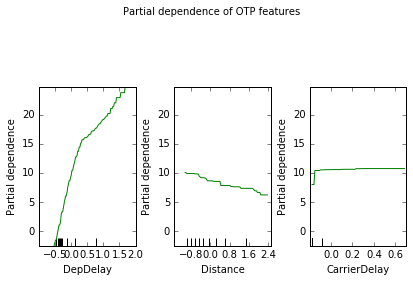

In [6]:
#Model for partial dependency plots
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

GBr = GradientBoostingRegressor(n_estimators=100, max_depth=4,
                                learning_rate=0.1, loss='huber',
                                random_state=2)
GBr.fit(X_train, y_train)

selected_features = OTPcorr.columns.values
features = [0,4,5] #DepDelay, Distance, CarrierDelay
fig, axs = plot_partial_dependence(GBr, X_train, features, feature_names = selected_features,
                                   n_jobs = -1, grid_resolution = 100)
fig.suptitle('Partial dependence of OTP features')
plt.show()


I built a really simple model for the soul purpose of further examination of features through partial dependence. I did not fine tune or grid search this model, as I had no intent of making predictions. I made three partial dependence plots for DepDelay, Distance, and CarrierDelay. It can be seen that when holding higher values constant accross the DepDelay feature, you will see much higher predictions in Arrival Delay. Also, for the Distance feature you can see a negative correlation. As higher values are held constant, you start to see lower predictions. CarrierDelay has weight, as interpreted from the beta coefficient. However, the range of values present in the dataset is not extensive enough to present something meaningful in this plot.  

In [21]:
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())

### Conclusions

There are clearly some limitations to the dataset. Only having data from August makes it extremely difficult to model the data over time and examine trends. Also, since the data is limited, examining certain statistics may be deceiving. An example of this was presented above when observing the mean arrival delay based on origin and destination state. Taking the mean of one data point will not tell you much about a how particular airline may be performing overall at these locations. 

Despite these complications, there were definitely some interesting results derived from the data. Since airlines are so susceptible to any sort event that may occur, you can derive these events from the data by examining how different airlines are affected. Seeing some sort of commonality would imply an event. Another interesting result was how distance correlates with arrival delay. This would seem to imply that airlines are not taking full advantage of potential speed increases. It would be interesting to explore the full dataset and see what more information could be derived.